

# Project: Investigate a Dataset - [Patient Data Analyses]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: I decided to invstigate the dataset No-show
appointments , its contain 
ScheduledDay
Neighborhood
Scholarship
NO-Show it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.
PatientId,
AppointmentID,
Gender,
AppointmentDay,
Age		,
Hipertension,	
Diabetes,
Alcoholism
,Handcap,
,SMS_received	

  [here]https://s3.amazonaws.com/video.udacity-data.com/topher/2018/July/5b57919a_data-set-options/data-set-options.pdf 

### Question(s) for Analysis
Is there relationship between age and Hipertension ?
Is there relationship between age and No-show?
Is there relationship between age and Diabetes?


In [3]:
# Use this cell to set up import statements for all of the packages that you
#   we are going to import all libraraies that we going to use in this project 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
%matplotlib inline 
# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


In [4]:
# Upgrade pandas to use dataframe.explode() function. 
# !pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [5]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
ds=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

ds.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No



### Data Cleaning
I will chech about null or na values , as we as age outlier then will agnore outlier and drop coulmns that not in demand .
 

In [6]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
##we are going to chech whither there is missiing value or nan 
ds.isna().sum().sum()

0

In [7]:
#check for missing data 
ds.isnull().sum().sum()


0

Text(0.5,0,'age')

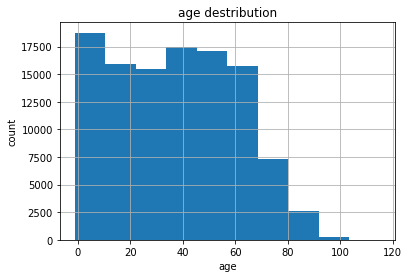

In [8]:
ds.Age.hist()
plt.title('age destribution')
plt.ylabel("count")
plt.xlabel('age')

from the above destribution its was clear lift tail distrution 

In [9]:
#summery statistic
ds.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [10]:
# I will drop columns that extra to research questions.
ds.drop(['SMS_received','Handcap','ScheduledDay','AppointmentDay','AppointmentDay'],axis=1,inplace=True)

In [11]:
#function to plot boxblot
def bocplot(y):
    plt.boxplot(y)
    
#
def myFunction(ds,xVar,yVar):
    plt.figure(figsize=[6,6])
    sns.stripplot(data=ds,x=xVar,y=yVar,
             jitter=0.30,color='steelblue',size=2)

Text(0,0.5,'age')

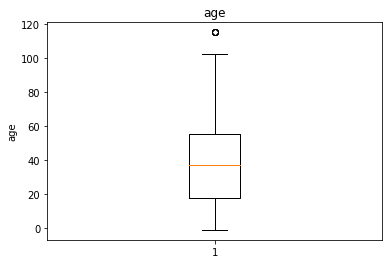

In [12]:
#'great the data is cleaned '
# I would try to find if there is outlier in age
age=ds['Age'] 
bocplot(age)
plt.title('age')
plt.ylabel('age')

this above boxplot is detect outlier , that circle on the top chart is outlier values , I will agnore it 

In [13]:
## I would agnore the outliar in age column
ds=ds.query('Age < 100')
x=ds['Age']   

Text(0.5,1,'age')

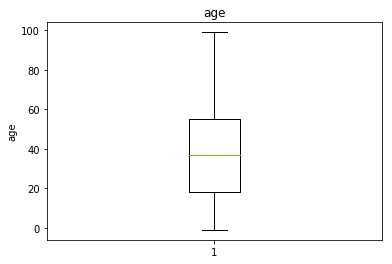

In [14]:
bocplot(x)
plt.ylabel("age")
plt.title('age')

 Now , its stable , since no outlier 

In [15]:
show_up=ds[ds['No-show']=='Yes']

In [16]:
show_up_corr=show_up.corr()
show_up_corr.head()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism
PatientId,1.000000,-0.006086,-0.000687,0.000087,0.000203,-0.005402,-0.007150
AppointmentID,-0.006086,1.000000,0.006234,0.022388,0.011719,0.032304,0.034373
Age,-0.000687,0.006234,1.000000,-0.079665,0.522260,0.307093,0.100037
Scholarship,0.000087,0.022388,-0.079665,1.000000,-0.023846,-0.024155,0.057862
Hipertension,0.000203,0.011719,0.522260,-0.023846,1.000000,0.439070,0.090327


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Is there relationship between age and Hipertension!)

Text(0,0.5,'frequencies')

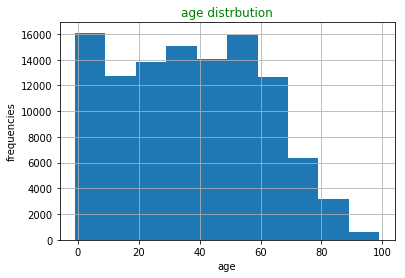

In [17]:
ds.Age.hist()
plt.xlabel('age')
plt.title('age distrbution',color='green')
plt.ylabel('frequencies')

the above shart shwos distribution of pateints ages , the most patient under 60 of thier old 

Text(0,0.5,'Age')

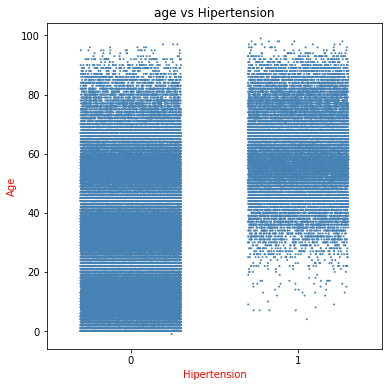

In [18]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
hipertension=ds['Hipertension']
age=ds['Age']
myFunction(ds,hipertension,age)

plt.title('age vs Hipertension')
plt.xlabel('Hipertension',color="red")
plt.ylabel('Age',color="red")



this shart show us the relation between age and hipertention , most of patiens with hipertention older thirty of thier age  

its clear that Hipertension related to age , probabilty going to be high as increasing of age

we are considering age as independent variable and  Hipertension dependent vaiable 

### Research Question 2 (Is there relationship between age and No-show'!)

In [26]:
attend=ds[ds['No-show']=='Yes']
absent=ds[ds['No-show']=='No']

Text(0,0.5,'frequencies')

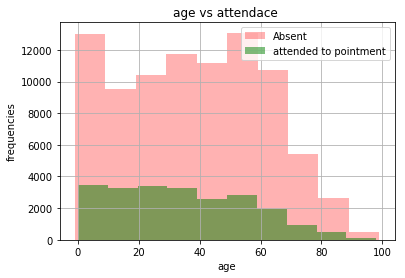

In [20]:
absent.Age.hist(color='red',alpha=.3,label='Absent')
attend.Age.hist(color='green',alpha=.5,label='attended to pointment')

plt.legend()
plt.title('age vs attendace ')
plt.xlabel('age')
plt.ylabel('frequencies')

This chart is explain the absence and attendance regrding patiens age, no significant difference 

Text(0,0.5,'Age')

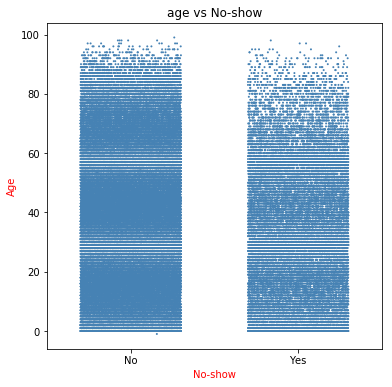

In [28]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
show=ds['No-show']
age=ds['Age']
myFunction(ds,show,age)
plt.title('age vs No-show')
plt.xlabel('No-show',color="red")
plt.ylabel('Age',color="red")

This chart is explain the absence and attendance regrding patiens age, no significant difference 

In [31]:
show_up=ds['No-show']=='Yes'
show_Down=ds['No-show']=='No'
ds.Diabetes[show_up].count()


22316

In [32]:
ds.Diabetes[show_Down].count()

88200

### Research Question 3 (Is there relationship between age and Diabetes!))

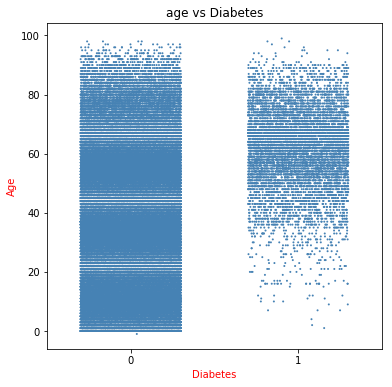

In [33]:
Diabetes=ds['Diabetes']
age=ds['Age']
myFunction(ds,Diabetes,age)
plt.title('age vs Diabetes')
plt.xlabel('Diabetes',color="red")
plt.ylabel('Age',color="red")
plt.show()

this chart show us how Diabetes effected by thier age , most of pateint with dabeteis above 40 of thier old , as long as person 
becom older he or she may develop daibates 

Conclusions

there is relatioship between age and Hipertention as people , there is  could be get hipertetion and young people most 
exclude the Hipertention.
second, 
there is relationship betwee age daibates as thier aging , most of patiens get dabetis when thier in 20s.
there is no clear age and shou-up in appointment , the age does not play essinatial role in appointment  

Limitation 

There is  missing features like income and job postion , that may declar other hiden information

In [25]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0